# Análisis de riesgo de una compañía aseguradora

- Instituto Tecnológico y de Estudios Superiores de Monterrey

| Alumno  | Matrícula |
| :-----: |  :-----:  |
| Verónica Victoria García De la Fuente | A00830383 |
| Emily Rebeca Méndez Cruz              | A00830768 |
| Daniel de Zamacona Madero             | A01570576 |
| Eugenio Santiesteban Zolezzi          | A01720932 |
| Juan Pablo Echeagaray González        | A00830646 |

- Profesores:
  - Dr. Fernando Elizalde Ramírez
  - Dr. Jaime Eduardo Martínez Sánchez
- Optimización estocástica
- 10 de septiembre del 2022

## Dependencias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.stats as st

from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.stats.gof import chisquare

from scipy.stats import spearmanr

from matplotlib import rc

rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)


## Lectura y procesamiento de datos

In [2]:
df = pd.read_csv('data/insurance-data.csv', encoding='latin-1')
print(df.shape)
df.head()


(27121, 8)


,Fecha del Siniestro,Tipo de auto,Modelo,Monto del siniestro,Aplica cobertura,Deducible,Reclamo de no-Cobertura,Pérdida total
0,01/12/2020,Deportivo,2017,200000,Si,NaN,Si,Si
1,12/05/2020,Austero,2016,100000,Si,NaN,Si,Si
2,11/01/2020,compacto,2017,150000,Si,NaN,Si,Si
3,21/12/2020,Subcompacto,2017,70000,Si,NaN,Si,Si
4,30/05/2020,Subcompacto,2019,90000,Si,NaN,Si,Si


In [3]:
df.dtypes


Fecha del Siniestro         object
Tipo de auto                object
Modelo                       int64
Monto del siniestro          int64
Aplica cobertura            object
Deducible                  float64
Reclamo de no-Cobertura     object
Pérdida total               object
dtype: object

Una buena práctica con el manejo de datos es asegurarnos de que sean representados por un _tipo_ de dato acorde al valor que representa la variable, esto ayudará a realizar operaciones con ellos, así como minimizar el espacio en memoria que ocupan. Cambiaremos también el nombre de las columnas para que sea más sencillo el proceso de desarrollo del modelo.

In [4]:
column_names = {'Fecha del Siniestro': 'date',
                'Tipo de auto': 'car_type',
                'Modelo': 'model',
                'Monto del siniestro': 'amount',
                'Aplica cobertura': 'coverage', 
                'Deducible': 'deductible', 
                'Reclamo de no-Cobertura': 'no_claim',
                'Pérdida total': 'total_loss'}

df.rename(columns=column_names, inplace=True)
df.head()


,date,car_type,model,amount,coverage,deductible,no_claim,total_loss
0,01/12/2020,Deportivo,2017,200000,Si,NaN,Si,Si
1,12/05/2020,Austero,2016,100000,Si,NaN,Si,Si
2,11/01/2020,compacto,2017,150000,Si,NaN,Si,Si
3,21/12/2020,Subcompacto,2017,70000,Si,NaN,Si,Si
4,30/05/2020,Subcompacto,2019,90000,Si,NaN,Si,Si


In [5]:
df.car_type.value_counts()


Austero        7664
Subcompacto    5322
Camioneta      5307
compacto       3937
Deportivo      2796
De Lujo        2072
Name: car_type, dtype: int64

De nuevo continuaremos con la tarea de limpieza de datos, tratando valores nulos, convirtiendo variables del tipo booleanas a una representación adecuada, y cambiando el formato de la columna que describe el momento en el que ocurrió un siniestro. Estas transformaciones facilitarán el proceso de análisis y visualización de los mismos datos.

In [6]:
car_map = {'Deportivo': 0, 
        'Austero': 1, 
        'compacto': 2, 
        'Subcompacto': 3,
        'Camioneta': 4,
        'De Lujo': 5
}
df['car_type'] = df['car_type'].map(car_map)
df['car_type'] = df['car_type'].fillna(99)
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
# Codificando variables booleanas a 0 y 1
df['coverage'] = df['coverage'].map({'Si': 1, 'No': 0})
df['no_claim'] = df['no_claim'].map({'Si': 1, 'No': 0})
df['total_loss'] = df['total_loss'].map({'Si': 1, 'No': 0})
df.head()


,date,car_type,model,amount,coverage,deductible,no_claim,total_loss
0,2020-12-01,0.0,2017,200000,1,NaN,1.0,1
1,2020-05-12,1.0,2016,100000,1,NaN,1.0,1
2,2020-01-11,2.0,2017,150000,1,NaN,1.0,1
3,2020-12-21,3.0,2017,70000,1,NaN,1.0,1
4,2020-05-30,3.0,2019,90000,1,NaN,1.0,1


Un último paso de limpieza que garantiza que nuestro proyecto sea válido, es solamente considerar aquellos casos en los que si aplicó el seguro; este trabajo no analizará aquellos casos en los que el seguro de los clientes de la empresa no haya podido actuar por el motivo que sea.

In [7]:
df_use = df[df['coverage'] == 1]


In [8]:
df_use.head()


,date,car_type,model,amount,coverage,deductible,no_claim,total_loss
0,2020-12-01,0.0,2017,200000,1,NaN,1.0,1
1,2020-05-12,1.0,2016,100000,1,NaN,1.0,1
2,2020-01-11,2.0,2017,150000,1,NaN,1.0,1
3,2020-12-21,3.0,2017,70000,1,NaN,1.0,1
4,2020-05-30,3.0,2019,90000,1,NaN,1.0,1


## Estimación de parámetros

La siguiente etapa del proyecto será analizar los montos pagados en cada siniestro así como la frecuencia con la que estos ocurren. Es de nuestro interés conocer las distribuciones tanto los respectivos parámetros que modelan estos fenómenos.

In [9]:
claims_per_day = df_use.groupby('date').count()['amount'].values


### Independencia entre el monto de reclamos y el número de reclamos

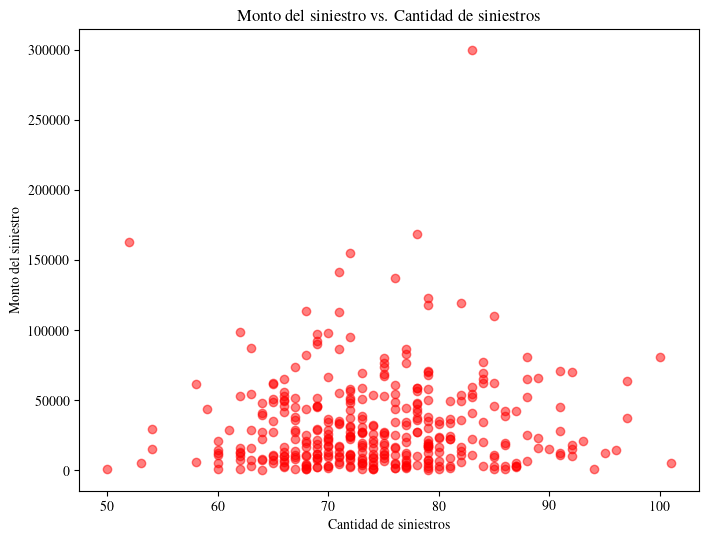

In [10]:
amounts_sample = df_use['amount'].sample(len(claims_per_day), replace=True, random_state=42)
plt.figure(figsize=(8,6))
plt.scatter(claims_per_day, amounts_sample, alpha=0.5, c='red')
plt.xlabel('Cantidad de siniestros')
plt.ylabel('Monto del siniestro')
plt.title('Monto del siniestro vs. Cantidad de siniestros')
plt.savefig('img/independent.png', dpi=300)
plt.show()


Se realiza una prueba de hipótesis para verificar que no existe una alta correlación entre estas 2 variables numéricas, se propone que si el índice de correlación es alto, podemos sospechar de la existencia de una dependencia entre estas 2 mismas variables:
$$\begin{gather*}
    H_0: \rho = 0\\
    H_1: \rho \neq 0
\end{gather*}$$

In [11]:
corr_test = spearmanr(claims_per_day, amounts_sample, alternative='two-sided')
print(f'Correlation coefficient: {corr_test[0]}')
print(f'p-value: {corr_test[1]}')

Correlation coefficient: 0.06501552624918046
p-value: 0.21528227094521143


### Sobre el monto de los siniestros

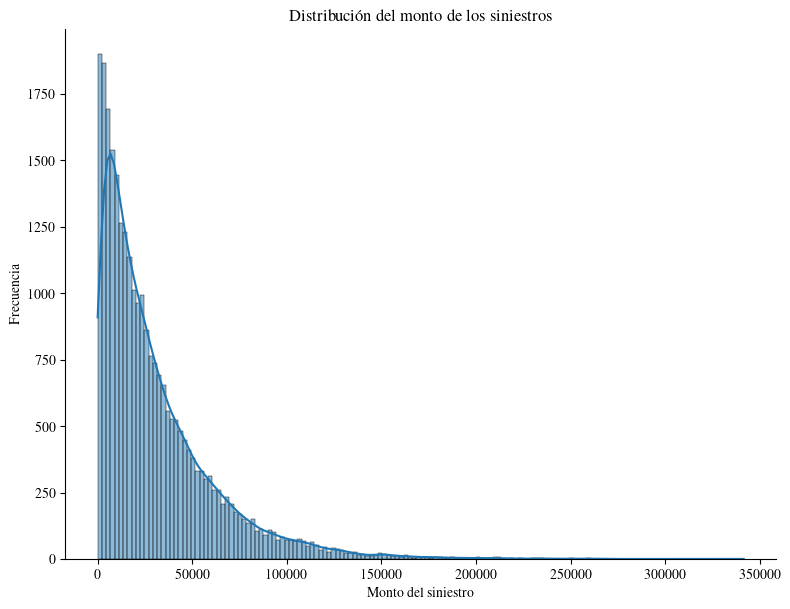

In [12]:
sns.displot(df_use['amount'], height=6, aspect=8/6, kde=True)
plt.xlabel('Monto del siniestro')
plt.ylabel('Frecuencia')
plt.title('Distribución del monto de los siniestros');
plt.savefig('img/amount_dist.png', dpi=300, bbox_inches='tight')
plt.show()


Una primera visualización de los montos de los siniestros nos haría pensar que una distribución exponencial podría ser bien ajustada a nuestros datos muestrales. Empíricamente podemos observar un pico al comienzo de la gráfica, y un continuo descenso hacia frecuencias de 0 para los montos más elevados registrados en la base de datos.

#### Prueba de hipótesis sobre la distribución del monto de los siniestros

<!-- @article{lilliefors1969kolmogorov,
  title={On the Kolmogorov-Smirnov test for the exponential distribution with mean unknown},
  author={Lilliefors, Hubert W},
  journal={Journal of the American Statistical Association},
  volume={64},
  number={325},
  pages={387--389},
  year={1969},
  publisher={Taylor \& Francis}
} -->

Realizaremos una prueba de hipótesis para ver si existe información estadística suficiente como para aseverar que el monto de los reclamos sigue una distribución exponencial $X \sim \text{Exp}(\lambda = 32198.560688)$, realizaremos esta prueba con un nivel de significancia $\alpha = 0.01$. Como método de prueba usaremos Lilliefors, propuesto en su artículo XXXX:

$$\begin{gather*}
    H_o: X \sim \text{Exp}(\lambda) \\
    H_a: X \not \sim \text{Exp}(\lambda)
\end{gather*}$$

> Lilliefors, H. W. (1969). On the Kolmogorov-Smirnov test for the exponential distribution with mean unknown. Journal of the American Statistical Association, 64(325), 387-389.

In [13]:
stat, p_val = lilliefors(df_use['amount'], dist='exp', pvalmethod='approx')
print(f'Test Statistic: {stat}, p-value: {p_val}')


Test Statistic: 0.005893921934550128, p-value: 0.09746160734913081


El `p-value` obtenido no es menor al nivel de significancia que hemos establecido para nuestra prueba, por lo que hemos fallado el rechazo de la hipótesis nula. De ahora en adelante supondremos que los montos de los siniestros siguen una distribución exponencial.
$$\begin{equation}
    X \sim \text{Exp}(\lambda)
\end{equation}$$

#### Prueba de hipótesis sobre la media del monto

Sabiendo que la distribución exponencial modela esta variable aleatoria, queremos ahora saber el parámetro que mejor se ajuste a nuestros datos. Dado que el parámetro $\lambda$ de la distribución exponencial es equivalente a la media de la población, supondremos que el parámetro puede ser aproximado por la media muestral de esta variable.

In [14]:
mean_amount = df_use['amount'].describe()['mean']
print(f'Lambda = {mean_amount}')


Lambda = 30771.375686737214


Realizamos ahora una prueba de hipótesis con una signifcancia $\alpha = 0.05$ para la media de los montos de los siniestros:
$$\begin{gather*}
    H_o: \lambda = \bar{\lambda} \\
    H_a: \lambda \neq \bar{\lambda}
\end{gather*}$$

Como tenemos una muestra con más de 27,000 valores, podremos suponer que por el Teorema Central del Límite la media sigue una distribución normal; así que una prueba de hipótesis `t-student` bastará para comprobar nuestro supuesto.

In [15]:
st.ttest_1samp(df_use['amount'], mean_amount)


Ttest_1sampResult(statistic=0.0, pvalue=1.0)

El `p-value` que hemos obtenido no es menor al nivel de significancia establecido, por lo que no podemos rechazar la hipótesis nula. Supondremos que la media muestral de nuestra base de datos es representativa de la media poblacional.

Ahora podemos modelar la variable aleatoria de los montos como:
$$\begin{equation}
    X \sim \text{Exp}(\lambda = 30,771.375)
\end{equation}$$

#### Intervalo de confianza para la media de los siniestros

Finalmente, es de nuestro interés conocer un intervalo de confianza para nuestra estimación; seguiremos la misma convención de usar un nivel de significancia del $0.05$, y aprovecharemos el Teorema Central del Límite aplicado a medias para calcular nuestro intervalo de confianza como:
$$\begin{equation}
    CI = \bar{x} \pm z_{\alpha} \frac{s}{\sqrt{n}}
\end{equation}$$

In [16]:
alpha = 0.05
CI_amount = st.norm.interval(1 - alpha, loc=mean_amount, scale=st.sem(df_use['amount']))
print(f'CI ({(1-alpha) * 100}%) = {CI_amount}')


CI (95.0%) = (30399.679941166123, 31143.071432308305)


### Sobre el número de reclamos por día

Ahora nos gustaría conocer qué proceso modela el número de reclamos por día. Sabemos de antemano que este es un proceso estocástico de conteo; así que una de las opciones de modelado más atractivas es la del proceso de Poisson. Primero observaremos la distribución de nuestros datos.

In [17]:
sample_size = claims_per_day.shape[0]
mean_claims_per_day = np.mean(claims_per_day)
std_claims_per_day = np.std(claims_per_day)
var = np.var(claims_per_day)
print(f'''Estadísticos:
Sample size: {sample_size}
Mean claims per day: {mean_claims_per_day}
Standard deviation: {std_claims_per_day}
Variance: {var}''')


Estadísticos:
Sample size: 365
Mean claims per day: 74.30410958904109
Standard deviation: 8.423587859478074
Variance: 70.95683242634641


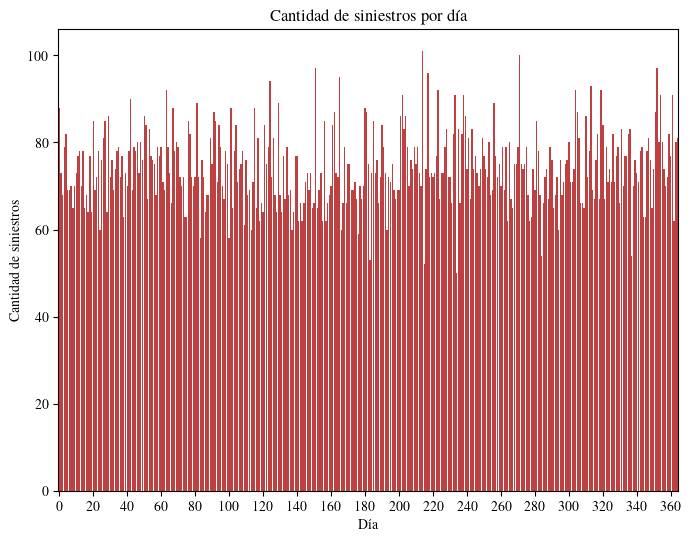

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.barplot(x=np.arange(0, sample_size), y=claims_per_day, color='red', saturation=0.5)
ax.set_title('Cantidad de siniestros por día')
ax.set_xlabel('Día')
ax.set_ylabel('Cantidad de siniestros')
new_ticks = [i.get_text() for i in ax.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 20), new_ticks[::20])
plt.savefig('img/claims_per_day.png', dpi=300)
plt.show()


#### Prueba de hipótesis sobre la distribución del número de reclamos por día

Para demostrar que este proceso es Poisson homogéneo, aprovecharemos que un proceso de Poisson homogéneo sigue una distribución Poisson. Realizaremos una prueba de bondad de ajuste `chi-square` para determinar si es que esa distribución se ajusta a nuestro proceso estocástico. Usaremos un nivel de significancia del 0.05:

$$\begin{gather*}
    H_o: X_t \sim \text{Poi}(\lambda t) \\
    H_a: X_t \not \sim \text{Poi}(\lambda t)
\end{gather*}$$

In [19]:
test_sample = np.random.poisson(mean_claims_per_day, sample_size)

chisquare(claims_per_day, test_sample, value=0.15)


(642.0358690184153, 0.9999999999785233)

El `p-value` que hemos calculado no es menor que el nivel de significancia establecido, por lo que modelaremos este proceso estocástico como un proceso de Poisson homogéneo.

#### Prueba de hipótesis sobre la media del número de reclamos por día

Realizamos una prueba de hipótesis sobre la media del número de reclamos, el parámetro que deseamos estimar es también el parámetro que necesita un proceso de Poisson. De nuevo aprovecharemos el Teorema Central del Límite para suponer que esta media sigue una distribución normal, hay que recordar que para este dato tenemos concretamente 365 observaciones. Usaremos un nivel de significancia del 0.05:
$$\begin{gather*}
    H_o: \lambda = \bar{\lambda} \\
    H_a: \lambda \neq \bar{\lambda}
\end{gather*}$$


In [20]:
st.ttest_1samp(claims_per_day, mean_claims_per_day)

Ttest_1sampResult(statistic=0.0, pvalue=1.0)

#### Intervalo de confianza para la media del número de reclamos por día

Aquí también es de nuestro interés conocer un intervalo de confianza para nuestra estimación; seguiremos la misma convención de usar un nivel de significancia del $0.05$, y aprovecharemos el Teorema Central del Límite aplicado a medias para calcular nuestro intervalo de confianza como:
$$\begin{equation}
    CI = \bar{x} \pm z_{\alpha} \frac{s}{\sqrt{n}}
\end{equation}$$

In [21]:
alpha = 0.05
CI_claims = st.norm.interval(1 - alpha, loc=mean_claims_per_day, scale=st.sem(claims_per_day))
print(f'CI ({(1-alpha) * 100}%): {CI_claims}')


CI (95.0%): (73.43875418690106, 75.16946499118112)


## Simulaciones

In [22]:
mean_amount = df_use['amount'].describe()['mean']
mean_claims = df_use.groupby('date').count()['amount'].mean()
print(f'Mu = {mean_amount}')
print(f'Lambda = {mean_claims}')


Lambda = 30771.375686737214
Mean claims per day = 74.30410958904109


### Total del reclamo por instante $t$

In [23]:
def generate_claims(claim_rate: float, mean_amount: float) -> float:
    number_claims = np.random.poisson(claim_rate)
    amount = np.random.exponential(mean_amount, number_claims)
    return np.sum(amount)


### Detectando ruinas

In [24]:
def test_ruin(T: int, claim_rate: float, mean_amount: float, initial_equity: float, c: float) -> tuple:
    U = np.array([])
    # S1 = generate_claims(claim_rate, mean_amount)
    P = c
    U = np.append(U, initial_equity)

    R = 0
    for i in range(1, T):
        S = generate_claims(claim_rate, mean_amount)
        new_U = U[i-1] + P - S
        U = np.append(U, new_U)
        if U[i] < 0:
            R += 1
            break

    return R, U


### Método de Monte Carlo Crudo

In [25]:
def ruin_prob(n_sim: int, T: int, claim_rate: float, mean_amount: float, initial_equity: float, c: float, alpha: float) -> tuple:
    ruins = np.array([])
    paths = []

    for _ in range(int(n_sim)):
        R, U = test_ruin(T, claim_rate, mean_amount, initial_equity, c)
        ruins = np.append(ruins, R)
        paths.append(U)
    
    CI = proportion_confint(sum(ruins), n_sim, alpha=alpha, method='normal')

    return np.mean(ruins), paths, CI


### Probabilidad de ruina analítica. Fórmula de Pollaczcek-Khinchin

$$\begin{gather*}
    u := \text{Capital inicial} \\
    \theta := \text{Factor de recargo} \\
    \alpha := \frac{1}{\lambda_Z} \\
    \psi(u) = \frac{1}{1 + \theta} \cdot \exp \left(u \frac{\alpha \theta}{1 + \theta} \right)
\end{gather*}$$

In [26]:
def pollaczek_khinchin(theta: float, u: float, lam_z: float) -> float:
    alpha = 1 / lam_z
    prob = (1 / (1 + theta)) * np.exp(- alpha * u * (theta / (1 + theta)))
    return prob


In [27]:
U0 = 1000000
alpha = 0.05
# Factor de recargo
theta = 0.05
c = (1 + theta) * mean_claims * mean_amount
print(f'c = {c}')
N_SIM = 10000
T = 5000
ruins, paths, CI = ruin_prob(N_SIM, T, mean_claims, mean_amount, U0, c, alpha)
print(f'P(Ruins): {ruins}')
print(f'CI ({(1-alpha) * 100}%): {CI}, Error = {0.5 * (CI[1] - CI[0])}')
p_analytic = pollaczek_khinchin(theta, U0, mean_amount)
print(f'P(Ruins) (analytic): {p_analytic}')


c = 2400761.65479452
P(Ruins): 0.1503
CI (95.0%): (0.14329577013327266, 0.15730422986672732), Error = 0.0070042298667273295
P(Ruins) (analytic): 0.20264464825498166


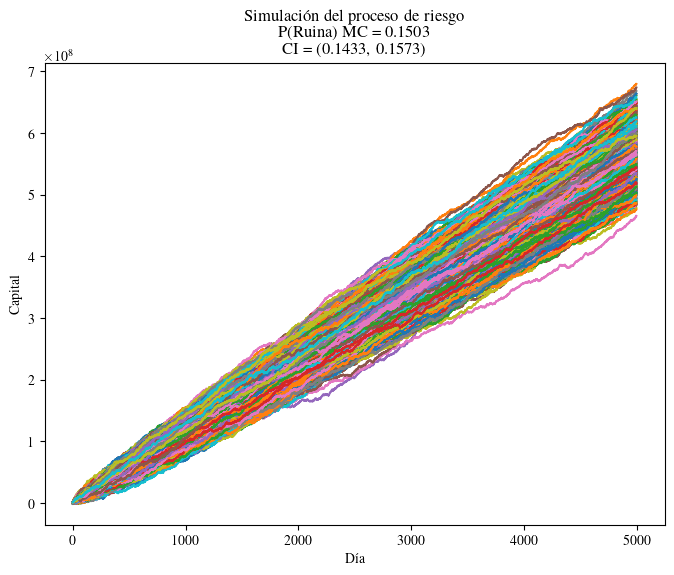

In [28]:
plt.figure(figsize=(8, 6))
plt.title(f'Simulación del proceso de riesgo \n P(Ruina) MC = {ruins} \n CI = ({CI[0]:.4f}, {CI[1]:.4f})')
plt.xlabel('Día')
plt.ylabel('Capital')
for path in paths:
    plt.plot(path)

plt.savefig(f'img/ruin_sim_U0{U0}_T{T}_Theta{theta}_N{N_SIM}.png', dpi=300, bbox_inches='tight')
plt.show()


## Probabilidades analíticas

### Variación del factor de recargo

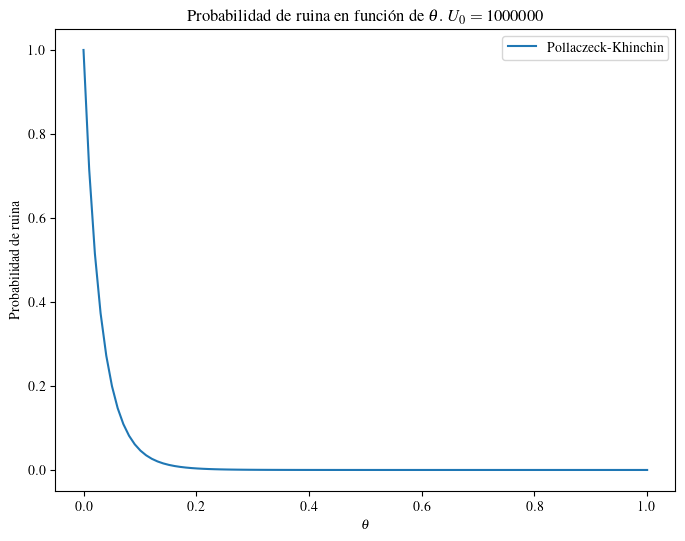

In [29]:
def test_theta():
    # Variando theta
    pos_theta = np.linspace(0, 1, 100)
    prob = np.array([])
    for theta in pos_theta:
        prob = np.append(prob, pollaczek_khinchin(theta, U0, mean_amount))

    # Visualización de resultados
    plt.figure(figsize=(8, 6))
    plt.title(r'Probabilidad de ruina en función de $\theta$. $U_0 = 1000000$')
    plt.xlabel(r'$\theta$')
    plt.ylabel('Probabilidad de ruina')
    plt.plot(pos_theta, prob, label='Pollaczeck-Khinchin')
    plt.legend()
    plt.savefig('img/theta.png', dpi=300, bbox_inches='tight')
    plt.show()

test_theta()

### Variación del capital inicial

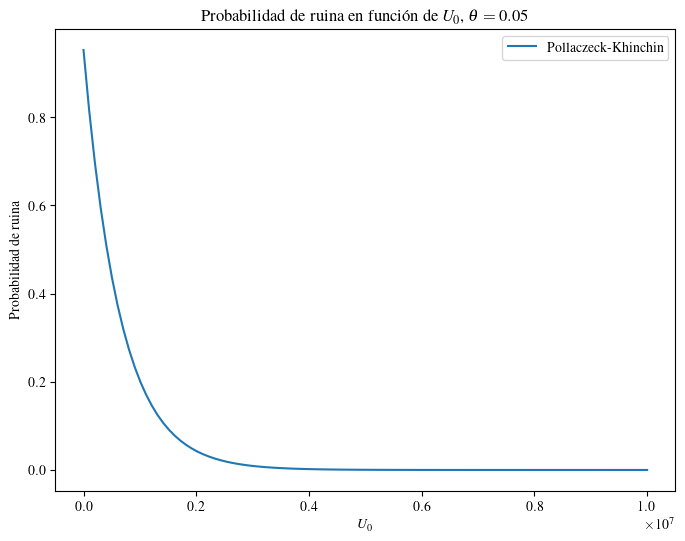

In [30]:
def test_u0():
    U = np.linspace(0, 1e7, 100)
    prob = np.array([])
    for u in U:
        prob = np.append(prob, pollaczek_khinchin(theta, u, mean_amount))

    # Visualización de resultados
    plt.figure(figsize=(8, 6))
    plt.title(r'Probabilidad de ruina en función de $U_0$, $\theta = 0.05$')
    plt.xlabel(r'$U_0$')
    plt.ylabel('Probabilidad de ruina')
    plt.plot(U, prob, label='Pollaczeck-Khinchin')
    plt.legend()
    plt.savefig('img/u0.png', dpi=300, bbox_inches='tight')
    plt.show()

test_u0()